<a href="https://colab.research.google.com/github/StephenJudeD/StephenJudeD/blob/main/KNN_ML_CA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### KNN Recommendation system



Dataset Source: https://www.kaggle.com/datasets/nikdavis/steam-store-games

Dataset Description: Using data gathered from the Steam Store and SteamSpy APIs, this dataset provides information about various aspects of games on the store, such as its genre and the estimated number of owners. I did a v-lookup on the description data to remove anything that wasn't corresponding to main df

Objective: Provide recommendations based on input

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [1]:
from google.colab import files
 
 
uploaded = files.upload()

Saving steam.csv to steam.csv
Saving steam_description_data.csv to steam_description_data.csv


In [4]:
import io

df = pd.read_csv(io.BytesIO(uploaded['steam.csv']))
print(df)

     appid                           name release_date  english  \
0       10                 Counter-Strike   01/11/2000        1   
1       20          Team Fortress Classic   01/04/1999        1   
2       30                  Day of Defeat   01/05/2003        1   
3       40             Deathmatch Classic   01/06/2001        1   
4       50      Half-Life: Opposing Force   01/11/1999        1   
..     ...                            ...          ...      ...   
994  65740  Carrier Command: Gaea Mission   28/09/2012        1   
995  65780             ARMA: Gold Edition   13/07/2011        1   
996  65790         ARMA: Cold War Assault   08/08/2011        1   
997  65800              Dungeon Defenders   18/10/2011        1   
998  65930  The Bureau: XCOM Declassified   22/08/2013        1   

                developer             publisher          platforms  \
0                   Valve                 Valve  windows;mac;linux   
1                   Valve                 Valve  window

In [5]:
df1 = pd.read_csv(io.BytesIO(uploaded['steam_description_data.csv']))
print(df)

     appid                           name release_date  english  \
0       10                 Counter-Strike   01/11/2000        1   
1       20          Team Fortress Classic   01/04/1999        1   
2       30                  Day of Defeat   01/05/2003        1   
3       40             Deathmatch Classic   01/06/2001        1   
4       50      Half-Life: Opposing Force   01/11/1999        1   
..     ...                            ...          ...      ...   
994  65740  Carrier Command: Gaea Mission   28/09/2012        1   
995  65780             ARMA: Gold Edition   13/07/2011        1   
996  65790         ARMA: Cold War Assault   08/08/2011        1   
997  65800              Dungeon Defenders   18/10/2011        1   
998  65930  The Bureau: XCOM Declassified   22/08/2013        1   

                developer             publisher          platforms  \
0                   Valve                 Valve  windows;mac;linux   
1                   Valve                 Valve  window

In [6]:
# Total size
df.shape

(999, 18)

In [8]:
# Combining dataframes
df = df.rename(columns={'appid':'steam_appid'})
united_df = df.merge(df1, on='steam_appid')

# Removing unused columns
united_df = united_df.drop(['release_date',
                            'platforms',
                            'required_age',
                            'achievements',
                            'average_playtime',
                            'median_playtime',
                            'owners',
                            'price',
                            'about_the_game',
                            'categories',
                            'publisher',
                            'detailed_description'],1)

# Creating a rating difference
united_df['rating_difference'] = united_df['positive_ratings'] - united_df['negative_ratings']

# Removing games with negative and very low ratings to help with pour predictions
united_df = united_df.drop(united_df[united_df['rating_difference'] <= 10].index).reset_index(drop=True)

# Removing games without English translation as thats how i roll
united_df = united_df.drop(united_df[united_df['english'] == 0].index).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [9]:
# Quick look at our data - there is alo going on
united_df.info

<bound method DataFrame.info of      steam_appid                           name  english  \
0             10                 Counter-Strike        1   
1             20          Team Fortress Classic        1   
2             30                  Day of Defeat        1   
3             40             Deathmatch Classic        1   
4             50      Half-Life: Opposing Force        1   
..           ...                            ...      ...   
799        65730            Take On Helicopters        1   
800        65780             ARMA: Gold Edition        1   
801        65790         ARMA: Cold War Assault        1   
802        65800              Dungeon Defenders        1   
803        65930  The Bureau: XCOM Declassified        1   

                developer                      genres  \
0                   Valve                      Action   
1                   Valve                      Action   
2                   Valve                      Action   
3                  

In [10]:
# Null values
united_df.isnull().sum()

steam_appid          0
name                 0
english              0
developer            0
genres               0
steamspy_tags        0
positive_ratings     0
negative_ratings     0
Unnamed: 1           0
short_description    0
rating_difference    0
dtype: int64

In [11]:
# Total size 
united_df.shape

(804, 11)

**Lets have a look at the Data**

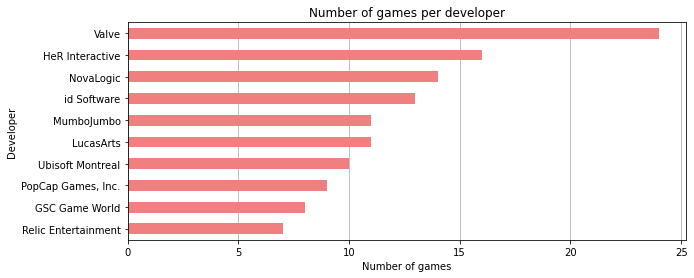

In [12]:
# Always good to have a Visualisation

# Selecting the required part of the dataframe
dev_head = united_df['developer'].value_counts().head(10)

# Create a figure
fig1, ax1 = plt.subplots(figsize=(10,4))

# Building a graph from a series
dev_head.plot(kind='barh', color='lightcoral', ax=ax1)

# Changing the order of lines on the chart
plt.gca().invert_yaxis()

# Sign the axes and give the name
plt.title('Number of games per developer')
plt.xlabel('Number of games')
plt.ylabel('Developer')

# Draw vertical lines
plt.grid(axis='x')
ax1.set_axisbelow(True)
plt.show()

In [13]:
# As always with text data, we need to do some cleansing to our model will perfomr better

In [14]:
# Separating tags with a space
def globalization(strok:str):
    return strok.replace(';', ' ')

# Removing duplicate tags
def del_rep(strok:str):
    spl_strok = strok.split()
    return ' '.join(sorted(set(spl_strok), key=spl_strok.index))

# Converting to lower case
def to_low(strok:str):
    return strok.lower()

In [15]:
# Separating tags with a space
united_df['genres'] = united_df['genres'].apply(globalization)
united_df['steamspy_tags'] = united_df['steamspy_tags'].apply(globalization)

# Combining genres and tags
united_df['genres&tags'] = united_df['genres'] + ' ' + united_df['steamspy_tags']

# Removing duplicate tags
united_df['genres&tags'] = united_df['genres&tags'].apply(del_rep)

# Convert strings to lowercase and concatenate into one column
cols = ['developer', 'genres&tags']
united_df['alls'] = united_df['name'].copy().apply(to_low)
for i in cols:
  united_df['alls'] += ' ' + united_df[i].apply(to_low)

In [16]:
# How it looks
united_df['alls']

0            counter-strike valve action fps multiplayer
1      team fortress classic valve action fps multipl...
2      day of defeat valve action fps world war ii mu...
3        deathmatch classic valve action fps multiplayer
4      half-life: opposing force gearbox software act...
                             ...                        
799    take on helicopters bohemia interactive simula...
800    arma: gold edition bohemia interactive action ...
801    arma: cold war assault bohemia interactive act...
802    dungeon defenders trendy entertainment action ...
803    the bureau: xcom declassified 2k marin action ...
Name: alls, Length: 804, dtype: object

In [17]:
#By calculating the cosine similarity for each game, we can determine how similar they are.

# Convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(stop_words='english')
count_matrix = vectorizer.fit_transform(united_df['alls'])

# Compute cosine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [18]:
# text-like strings, it is better to use the TfidfVectorizer
# Convert a collection of raw documents to a matrix of TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(united_df['short_description'])

# Stack sparse matrices horizontally
st = hstack([count_matrix, tfidf_matrix])

# Using hstack, you can combine matrices and calculate the cosine convergence so that when making recommendations
# Compute cosine similarity
cosine_sim2 = cosine_similarity(st, st)

**Model Building**

In [19]:
# This function makes 10 recommendations based on the calculated cosine similarity. 
# In this case, there are two options: 
# 1.recommendations based on title, developer and tags, 
# 2.and the same recommendations, but using a short description

# The main function that makes recommendations
def getNeighbors(nam:str, cosine):
#     Determine the index
    ind = united_df[united_df['name'] == nam].index.to_list()[0]
    
#     Obtaining cosine convergence by index
    cos_scor = list(enumerate(cosine[ind]))
    
#     Getting the most suitable games
    cos_scor = sorted(cos_scor, key=lambda x: x[1], reverse=True)
    cos_scor = cos_scor[1:8]
    ten_ind = [i[0] for i in cos_scor]
    return united_df['name'].iloc[ten_ind]

**Predictions**

Just drop a name to check a game - you have to use full names

In [20]:
united_df['name']

0                     Counter-Strike
1              Team Fortress Classic
2                      Day of Defeat
3                 Deathmatch Classic
4          Half-Life: Opposing Force
                   ...              
799              Take On Helicopters
800               ARMA: Gold Edition
801           ARMA: Cold War Assault
802                Dungeon Defenders
803    The Bureau: XCOM Declassified
Name: name, Length: 804, dtype: object

**Example 1**

In [21]:
# Example 1
naz = "S.T.A.L.K.E.R.: Shadow of Chernobyl"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(getNeighbors(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(getNeighbors(naz, cosine_sim2))

Recommendation for S.T.A.L.K.E.R.: Shadow of Chernobyl 

Recommendations using game name, developer, genre and tags 

655        S.T.A.L.K.E.R.: Call of Pripyat
378              S.T.A.L.K.E.R.: Clear Sky
410                              Fallout 3
415    Fallout 3: Game of the Year Edition
797                               Gothic 1
416                     Fallout: New Vegas
622                              Gothic® 3
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
655        S.T.A.L.K.E.R.: Call of Pripyat
378              S.T.A.L.K.E.R.: Clear Sky
410                              Fallout 3
415    Fallout 3: Game of the Year Edition
416                     Fallout: New Vegas
797                               Gothic 1
622                              Gothic® 3
Name: name, dtype: object


**Example 2**

In [22]:
# Example 2
naz = "Call of Duty® 4: Modern Warfare®"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(getNeighbors(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(getNeighbors(naz, cosine_sim2))

Recommendation for Call of Duty® 4: Modern Warfare® 

Recommendations using game name, developer, genre and tags 

234    Call of Duty®: Modern Warfare® 2
66                      Call of Duty® 2
65                        Call of Duty®
731                       Borderlands 2
5                              Ricochet
0                        Counter-Strike
3                    Deathmatch Classic
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
234    Call of Duty®: Modern Warfare® 2
66                      Call of Duty® 2
65                        Call of Duty®
731                       Borderlands 2
5                              Ricochet
667            Call of Duty®: Black Ops
0                        Counter-Strike
Name: name, dtype: object


**Example 3**

In [23]:
# Example 3
naz = "Borderlands 2"
print('Recommendation for', naz, '\n')
print('Recommendations using game name, developer, genre and tags \n')
print(getNeighbors(naz, cosine_sim),'\n')
print(print('Recommendations using game name, developer, genre, tags and description \n'))
print(getNeighbors(naz, cosine_sim2))

Recommendation for Borderlands 2 

Recommendations using game name, developer, genre and tags 

199                   BioShock Infinite
202         Sid Meier's Civilization® V
66                      Call of Duty® 2
186    Call of Duty® 4: Modern Warfare®
234    Call of Duty®: Modern Warfare® 2
435                   PAYDAY™ The Heist
759                  Duke Nukem Forever
Name: name, dtype: object 

Recommendations using game name, developer, genre, tags and description 

None
199                   BioShock Infinite
202         Sid Meier's Civilization® V
186    Call of Duty® 4: Modern Warfare®
234    Call of Duty®: Modern Warfare® 2
66                      Call of Duty® 2
435                   PAYDAY™ The Heist
759                  Duke Nukem Forever
Name: name, dtype: object
